# High order Prince methods & Riccati equation

[Prince](http://www.peteprince.co.uk/parallel.pdf) has developed some interesting high order methods. These are demonstated on problem A2 from the [DETEST](http://perso.ensta-paristech.fr/~chapoutot/integration/docs/p1-enright.pdf) set: a special case of the Riccati equation.

## Problem definition

The initial value problem is:

In [1]:
problem = {'fun' : lambda x, y: -y**3/2,
            'y0' : [1.],
        't_span' : [0., 20.]}

## Reference solution

This problem has an analytic solution that will be used as reference:

In [2]:
reference = lambda x: (x+1)**-0.5

## Solution plot

The plot below shows the solution. It's a simple, smooth curve.

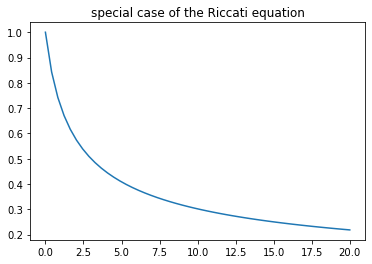

In [3]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

t = np.linspace(*problem['t_span'])

plt.figure()
plt.plot(t, reference(t))
plt.title('special case of the Riccati equation')
plt.show()

## Efficiency plot

The efficiency of the methods can be assessed by making a plot of the error versus the number of derivative function evaluations. The error is calculated by the RMS norm:

In [4]:
def rms_err_norm(solution, reference):
    error = solution.y - reference(solution.t)
    err_norm = (error**2).mean()**0.5
    return err_norm

Let's solve this problem with `Pri6`, `Pri7` and `Pri8` at several absolute tolerance values and make a plot to show the efficiency of these methods. The scipy methods `RK45` and `DOP853` (with coefficients by Dormand and *Prince*) are included for comparison. The Riccati equation is solved efficiently by the new methods of Prince.

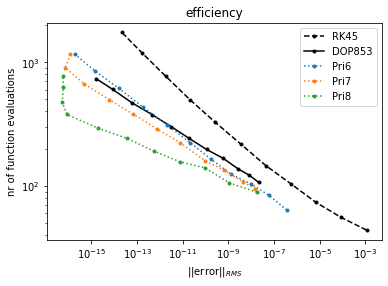

In [5]:
from scipy.integrate import solve_ivp
from extensisq import Pri6, Pri7, Pri8

methods = ['RK45', 'DOP853', Pri6, Pri7, Pri8]
tolerances = np.logspace(-3, -13, 11)

plt.figure()
for method in methods:
    name = method if isinstance(method, str) else method.__name__
    e = []
    n = []
    for tol in tolerances:
        sol = solve_ivp(**problem, rtol=1e-13, atol=tol, method=method,
                        dense_output=True) # this triggers extra evaluations in DOP853
        err = rms_err_norm(sol, reference)
        e.append(err)
        n.append(sol.nfev)
    if name == 'RK45':
        style = '--k.'
    elif name == 'DOP853':
        style = '-k.'
    else:
        style = '.:'
    plt.loglog(e, n, style, label=name)
plt.legend()
plt.xlabel(r'||error||$_{RMS}$')
plt.ylabel('nr of function evaluations')
plt.title('efficiency')
plt.show()    

## Discussion

The relative efficiency of the methods is problem dependent. For this problem, the efficiency graph shows:

* `DOP853` and `Pri7` are comparable. Both have a 7th order continous solution (interpolant) and a discrete method of order 8. The lines of these methods run parallel in the efficiency plot.
* Dense output was requested. This triggers extra evaluations in `DOP853`. *The methods of Prince don't require extra evaluations for dense output.* Without dense ouput, `DOP853` and `Pri7` have a similar efficiency for this problem.
* `Pri8` is the most efficient method at lower tolerance values.
* The curve of `Pri6` crosses that of `DOP853`.
* `RK45` is relatively inefficient at these tolerance values.
* The accuracy of all methods scale differently with the value of atol.
* The accuracy is limited to roughly 1e-16 in the extensisq implementation. This is shown as the vertical part of the efficiency curves of `Pri8` and `Pri7`. Setting the tolerance too low increases the number of function evaluations, but does not improve the solution any further.

I think that these methods by Prince are a useful addition to the default scipy methods for many problems that need to be solved with high accuracy.